In [157]:
# load dataset from "tripadvisor Paris"


In [158]:
from pymongo import MongoClient
import pandas as pd
import numpy as np

from datetime import datetime as dt
import matplotlib.pyplot as plt
import time
import datetime
from random import randint
import re

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize.regexp import WhitespaceTokenizer
import tensorflow as tf

In [192]:
# first traditional rule-based classifcation method
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [160]:
# connect to the db
client = MongoClient()
db = client.sentimentAnalysis

In [161]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentAnalysis')

In [162]:
def getCollection(colletName = ""):
    '''
    return pandas dataframe.
    '''
    cursor = db[collName].find({})
    df = pd.DataFrame(list(cursor))
    return df

In [163]:
# take Barcelona city hotel reviews as example
cityName = "barcelonaTripadvisor"
data = getCollection(colletName = cityName)

In [164]:
def label_sentiment_category(row):
    """
    split reviews into two categories, pos, labled by "1", neg, labeled by "0"
    [0, 1, 2] is neg, [4,5] is pos, 
    [3] is neutral, it needs to be deleted since we only do two-class classification
    """
    if row["score"] in [0, 1, 2]:
        return 0
    if row["score"] in [3]:
        return -1
    if row["score"] in [4, 5]:
        return 1


In [165]:
data['sentiment'] = data.apply(lambda row: label_sentiment_category(row),axis=1)

In [166]:
data[:2]

,_id,date,hotelLocation,hotelName,hotelStars,hotelUrl,review,score,title,url,userId,sentiment
0,5987192c9b1f26681686008e,"July 31, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,It truly felt like coming home when we came th...,5.0,SO SO Happy to Be BACK!,https://www.tripadvisor.com/ShowUserReviews-g1...,Lili1012,1
1,5987192e9b1f26681686008f,"July 26, 2017","Carrer Elisabets 11, 08001 Barcelona, Spain",Casa Camper Hotel Barcelona,4.0,https://www.tripadvisor.com/Hotel_Review-g1874...,Perfect place to stay in Barcelona.. We spent ...,5.0,Perfect,https://www.tripadvisor.com/ShowUserReviews-g1...,AimamKaur,1


In [167]:
print("data size : ", data.shape)

3072

In [168]:
# remove row where sentiment is neutral
data = data[data.sentiment != -1]

In [169]:
print("data shape after remove neutral reviews : ", data.shape)

2733

In [170]:
def clean_punc_and_marks(row):
    """
    remove punctuation, including ???????
    """
    words = nltk.word_tokenize(row["review"])

    words=[word.lower() for word in words if word.isalpha()]
    words = words[:250]
    return " ".join(words)

In [171]:
data['review'] = data.apply(lambda row: clean_punc_and_marks(row),axis=1)

In [172]:
X = data["review"]
y = data["sentiment"]

In [173]:
print("check the consistent size of reviews and sentiment : ", "review size : ", len(X), "sentiment size: ", len(y))

2733

2733

In [175]:
print(data[:2]["review"])

0    it truly felt like coming home when we came th...
1    perfect place to stay in we spent nights there...
Name: review, dtype: object

In [176]:
# in the future, using cross_validation technology
#reference paper
# Pang, B., Lee, L. and Vaithyanathan, S., 2002, July. 
#Thumbs up?: sentiment classification using machine learning techniques. 
#In Proceedings of the ACL-02 conference on Empirical methods in natural 
#language processing-Volume 10 (pp. 79-86). Association for Computational Linguistics.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

In [177]:
print("size shape for train data : ", X_train.shape)

2186

In [182]:
def cleanSentences(string):
    """
    removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
    """
    strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def getSentenceMatrix(sentence):
    arr = np.zeros([batchSize, maxSeqLength])
    sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter,word in enumerate(split):
        try:
            sentenceMatrix[0,indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix

In [188]:
def train_lstm():
    """
    train lstm model with hotel reviews
    """
    return 0

In [199]:
def clf_VADER():
    """
    reviews sentiment classification on VADER package
    """
    y_pred_VADER = list()
    analyzer = SentimentIntensityAnalyzer()
    for i in X_test:
        vs = analyzer.polarity_scores(i)
        if vs["compound"] > 0:
            y_pred_VADER.append(1)
        if vs["compound"] < 0:
            y_pred_VADER.append(0)
#         if the predicted review is neutral, then we set it as positive since we only have two categories
        if vs["compound"] == 0:
             y_pred_VADER.append(1)
    return y_pred_VADER
    

In [178]:

def clf_SVM():
    """
    train the model with stastical machine learning methods, here is linear SVC
    """
    start_time = time.time()

    # TASK: Build a vectorizer / classifier pipeline that filters out tokens
    # that are too rare or too frequent
    pipeline = Pipeline([
        ('vect', TfidfVectorizer(min_df=3, max_df=0.95)),
        ('clf', LinearSVC(C=1000)),
    ])

    # TASK: Build a grid search to find out whether unigrams or bigrams are
    # more useful.
    # Fit the pipeline on the training set using grid search for the parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
    }
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # TASK: print the mean and std for each candidate along with the parameter
    # settings for all the candidates explored by grid search.
    n_candidates = len(grid_search.cv_results_['params'])
    for i in range(n_candidates):
        print(i, 'params - %s; mean - %0.2f; std - %0.2f'
                 % (grid_search.cv_results_['params'][i],
                    grid_search.cv_results_['mean_test_score'][i],
                    grid_search.cv_results_['std_test_score'][i]))

    # TASK: Predict the outcome on the testing set and store it in a variable
    # named y_predicted
    y_predicted = grid_search.predict(X_test)

    # Print the classification report
    print(metrics.classification_report(y_test, y_predicted,
                                        target_names=None))
    elapsed_time = time.time() - start_time
    print("elapsed time: ", round(elapsed_time, 2), " seconds")

    # Print and plot the confusion matrix
    cm = metrics.confusion_matrix(y_test, y_predicted)
    print(cm)
    
    plt.matshow(cm)
    plt.show()
    return cmtrain

In [183]:
def clf_lstm():
    """
    using Long short time memory recurrent neural network model to do sentiment classification
    """
    # first step, load pre-trained model from others
    ids = np.load('idsMatrix.npy')
    wordVectors = np.load('./wordVectors.npy')
    wordsList = np.load('./wordsList.npy')
    print('Loaded the word list!')
    wordsList = wordsList.tolist() #Originally loaded as numpy array
    wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
    
    tf.reset_default_graph()

    labels = tf.placeholder(tf.float32, [batchSize, numClasses])
    input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

    data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
    data = tf.nn.embedding_lookup(wordVectors,input_data)

    lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.25)
    value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

    weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
    bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
    value = tf.transpose(value, [1, 0, 2])
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    prediction = (tf.matmul(last, weight) + bias)

    correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
    
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models'))
    
    y_pred = list()
    for i in X_test:
        inputMatrix = getSentenceMatrix(i)
        predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]
        if (predictedSentiment[0] > predictedSentiment[1]):
#         print "Positive Sentiment"
            y_pred.append(1)
        if (predictedSentiment[0] < predictedSentiment[1]):
#         print "Positive Sentiment"
            y_pred.append(0)
        if (predictedSentiment[0] == predictedSentiment[1]):
#         print "neural Sentiment"
            y_pred.append(1)
    return y_pred

0 params - {'vect__ngram_range': (1, 1)}; mean - 0.97; std - 0.01
1 params - {'vect__ngram_range': (1, 2)}; mean - 0.96; std - 0.00
             precision    recall  f1-score   support

          0       0.88      0.68      0.77        56
          1       0.96      0.99      0.98       491

avg / total       0.96      0.96      0.96       547

elapsed time:  2.74  seconds
[[ 38  18]
 [  5 486]]


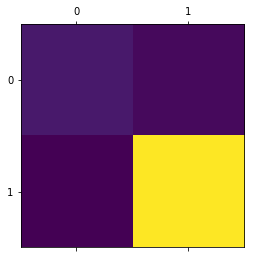

In [179]:
# test linear SVC algorithm
svm_clf = clf_SVM()

Loaded the word list!
INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-90000
elapsed time:  44.08  seconds for lstm
             precision    recall  f1-score   support

          0       0.48      0.73      0.58        56
          1       0.97      0.91      0.94       491

avg / total       0.92      0.89      0.90       547

[[ 41  15]
 [ 45 446]]


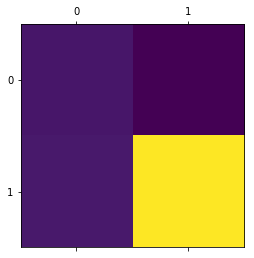

In [187]:
start_time_LSTM = time.time()
y_pred_lstm = clf_lstm()
elapsed_time_LSTM = time.time() - start_time
print("elapsed time: ", round(elapsed_time_LSTM, 2), " seconds for lstm")
# Print and plot the confusion matrix
cm_lstm = metrics.confusion_matrix(y_test, y_pred_lstm)
print(metrics.classification_report(y_test, y_pred_lstm,target_names=None))
print(cm_lstm)

plt.matshow(cm_lstm)
plt.show()

elapsed time:  0.73  seconds for VADER
             precision    recall  f1-score   support

          0       0.86      0.54      0.66        56
          1       0.95      0.99      0.97       491

avg / total       0.94      0.94      0.94       547

[[ 30  26]
 [  5 486]]


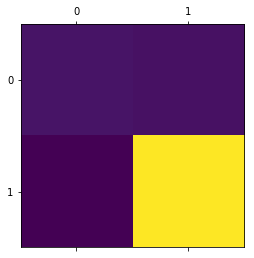

In [200]:
start_time = time.time()
y_pred_VADER = clf_VADER()
elapsed_time = time.time() - start_time
print("elapsed time: ", round(elapsed_time, 2), " seconds for VADER")
# Print and plot the confusion matrix
cm_VADER = metrics.confusion_matrix(y_test, y_pred_VADER)
print(metrics.classification_report(y_test, y_pred_VADER,target_names=None))
print(cm_VADER)

plt.matshow(cm_VADER)
plt.show()


In [191]:
# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",      # positive sentence example
            "VADER is not smart, handsome, nor funny.",   # negation sentence example
            "VADER is smart, handsome, and funny!",       # punctuation emphasis handled correctly (sentiment intensity adjusted)
            "VADER is very smart, handsome, and funny.",  # booster words handled correctly (sentiment intensity adjusted)
            "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
            "VADER is VERY SMART, handsome, and FUNNY!!!",# combination of signals - VADER appropriately adjusts intensity
            "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!",# booster words & punctuation make this close to ceiling for score
            "The book was good.",                                     # positive sentence
            "The book was kind of good.",                 # qualified positive sentence is handled correctly (intensity adjusted)
            "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
            "At least it isn't a horrible book.",         # negated negative sentence with contraction
            "Make sure you :) or :D today!",              # emoticons handled
            "Today SUX!",                                 # negative slang with capitalization emphasis
            "Today only kinda sux! But I'll get by, lol"  # mixed sentiment example with slang and constrastive conjunction "but"
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    if vs["compound"] > 0:
        
    print(vs)
#     print("{:-<65} {}".format(sentence, str(vs)))

{'neu': 0.254, 'neg': 0.0, 'pos': 0.746, 'compound': 0.8316}
{'neu': 0.354, 'neg': 0.646, 'pos': 0.0, 'compound': -0.7424}
{'neu': 0.248, 'neg': 0.0, 'pos': 0.752, 'compound': 0.8439}
{'neu': 0.299, 'neg': 0.0, 'pos': 0.701, 'compound': 0.8545}
{'neu': 0.246, 'neg': 0.0, 'pos': 0.754, 'compound': 0.9227}
{'neu': 0.233, 'neg': 0.0, 'pos': 0.767, 'compound': 0.9342}
{'neu': 0.294, 'neg': 0.0, 'pos': 0.706, 'compound': 0.9469}
{'neu': 0.508, 'neg': 0.0, 'pos': 0.492, 'compound': 0.4404}
{'neu': 0.657, 'neg': 0.0, 'pos': 0.343, 'compound': 0.3832}
{'neu': 0.579, 'neg': 0.327, 'pos': 0.094, 'compound': -0.7042}
{'neu': 0.637, 'neg': 0.0, 'pos': 0.363, 'compound': 0.431}
{'neu': 0.294, 'neg': 0.0, 'pos': 0.706, 'compound': 0.8633}
{'neu': 0.221, 'neg': 0.779, 'pos': 0.0, 'compound': -0.5461}
{'neu': 0.569, 'neg': 0.179, 'pos': 0.251, 'compound': 0.2228}


In [103]:

# train this model with my own train sample data, lstm model
def clf_neuralnetwork_first():
    numDimensions = 300
    maxSeqLength = 250
    batchSize = 24
    lstmUnits = 64
    numClasses = 2
    iterations = 100000
    
   
    wordsList = np.load('wordsList.npy').tolist()
    wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
    wordVectors = np.load('wordVectors.npy')
    
   
    tf.reset_default_graph()

    labels = tf.placeholder(tf.float32, [batchSize, numClasses])
    input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

    data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
    data = tf.nn.embedding_lookup(wordVectors,input_data)

    lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.25)
    value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

    weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
    bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
    value = tf.transpose(value, [1, 0, 2])
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    prediction = (tf.matmul(last, weight) + bias)

    correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
    
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('models'))
    
    # Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
    
    strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

    def cleanSentences(string):
        string = string.lower().replace("<br />", " ")
        return re.sub(strip_special_chars, "", string.lower())

    def getSentenceMatrix(sentence):
        arr = np.zeros([batchSize, maxSeqLength])
        sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
        cleanedSentence = cleanSentences(sentence)
        split = cleanedSentence.split()
        for indexCounter,word in enumerate(split):
            try:
                sentenceMatrix[0,indexCounter] = wordsList.index(word)
            except ValueError:
                sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
        return sentenceMatrix
    y_pred = list()
    for i in X_test_clean_punc:
        inputMatrix = getSentenceMatrix(i)
        predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]
        if (predictedSentiment[0] > predictedSentiment[1]):
#         print "Positive Sentiment"
            y_pred.append(1)
        if (predictedSentiment[0] < predictedSentiment[1]):
#         print "Positive Sentiment"
            y_pred.append(0)
        if (predictedSentiment[0] == predictedSentiment[1]):
#         print "neural Sentiment"
            y_pred.append(1)
    return y_pred
        
    

In [ ]:
# Print and plot the confusion matrix
cm_lstm = metrics.confusion_matrix(y_test, y_pred_lstm)
print(cm_lstm)

plt.matshow(cm_lstm)
plt.show()
return cm_lstm


In [ ]:
def clf_machinelearning_second(data):
    

In [69]:


def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

In [75]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 10
maxSeqLength = 250
# maxSeqLength = 10 #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector

In [73]:

tf.reset_default_graph()
tf.reset_default_graph()
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

In [78]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

In [79]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [80]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [81]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [82]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [86]:
wordsList = np.load('./wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8

Loaded the word list!


In [87]:
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(250,)
[    41    804 201534   1005     15   7446      5  13767      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0

In [88]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(250, 50)


In [89]:


tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [90]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels = getTrainBatch();
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
   #Write summary to Tensorboard
   if (i % 50 == 0):
       summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
       writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
   if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
writer.close()

In [102]:
X_test_clean_punc = list()
for review in X_test:
    X_test_clean_punc.append(remove_marks(review))

In [91]:
# label test hotel reviews as positive and negative
y_test_posneg = list()
for i in y_test:
    if i in [3,4,5]:
        y_test_posneg.append(1)
    if i in [0, 1,2]:
        y_test_posneg.append(0)
    

In [100]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters


def remove_marks(s):
    words = nltk.word_tokenize(s)

    words=[word.lower() for word in words if word.isalpha()]
    words = words[:250]
    return " ".join(words)


In [105]:
y_pred_lstm = clf_neuralnetwork_first()

start_time = time.time()
print(metrics.classification_report(y_test_posneg, y_pred_lstm,target_names=None))
elapsed_time = time.time() - start_time
print("elapsed time: ", round(elapsed_time, 2), " seconds for lstm")

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-90000
             precision    recall  f1-score   support

          0       0.35      0.70      0.47        56
          1       0.97      0.87      0.92       559

avg / total       0.91      0.86      0.88       615

elapsed time:  0.0  seconds for lstm
